Variant A — Transformer

Data Collection, preparation

In [1]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
"""
from torchtext import data, datasets


TEXT = data.Field(tokenize="basic_english", lower=True, batch_first=True)
LABEL = data.LabelField(dtype=None)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="data/")

print(len(train_data))
print(len(test_data))
print(vars(train_data.examples[0])["label"])
print(vars(train_data.examples[0])["text"][:20])
"""

downloading aclImdb_v1.tar.gz


imdb\aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [01:35<00:00, 883kB/s] 


25000
25000
pos
['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life']


In [ ]:
"""
import os
import csv


os.makedirs("cache", exist_ok=True)

with open("cache/imdb_train.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["label", "text"])
    for example in train_data.examples:
        label = example.label
        text = " ".join(example.text)
        writer.writerow([label, text])

with open("cache/imdb_test.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["label", "text"])
    for ex in test_data.examples:
        label = ex.label
        text = " ".join(ex.text)
        writer.writerow([label, text])

"""

In [4]:
from torchtext import data


TEXT = data.Field(tokenize="basic_english", lower=True, batch_first=True)
LABEL = data.LabelField(dtype=None)

fields = [("label", LABEL), ("text", TEXT)]

train_data = data.TabularDataset(
    path="cache/imdb_train.csv",
    format="csv",
    skip_header=True,
    fields=fields
)
test_data = data.TabularDataset(
    path="cache/imdb_test.csv",
    format="csv",
    skip_header=True,
    fields=fields
)

print("Train size:", len(train_data))
print("Test size:", len(test_data))

Train size: 25000
Test size: 25000


In [5]:
TEXT.build_vocab(train_data, max_size=20000, min_freq=2)
LABEL.build_vocab(train_data)

pad_idx = TEXT.vocab.stoi[TEXT.pad_token]
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

print(len(TEXT.vocab))
print(pad_idx, unk_idx)

20002
1 0


Iterator creation (Batchloader)

In [6]:
from torchtext import data


train_iter, test_iter = data.BucketIterator.splits(
    (train_data, test_data),
    batch_size=64,
    device=device,
    sort_key=lambda x:len(x.text),
    sort_within_batch=True
)

batch = next(iter(train_iter))
print(batch.text.shape)
print(batch.label.shape)

torch.Size([64, 185])
torch.Size([64])


Model TransformerClassifier

In [7]:
import torch.nn as nn
import math


class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_heads, num_layers, hidden_dim, num_classes, pad_idx, dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = embed_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, src, src_key_padding_mask):
        emb = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        emb = self.pos_encoder(emb)
        emb = self.dropout(emb)
        out = self.transformer(emb, src_key_padding_mask=src_key_padding_mask)
        out = out.mean(dim=1)
        out = self.layer_norm(out)
        out = self.fc(out)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)
    
    def forward(self, x):
        x += self.pe[:, :x.size(1)]
        return self.dropout(x)


In [8]:
model = TransformerClassifier(vocab_size=len(TEXT.vocab), embed_dim=128, n_heads=4, num_layers=2, hidden_dim=256, num_classes=2, pad_idx=pad_idx, dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Train function

In [9]:
def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in iterator:
        optimizer.zero_grad()

        src = batch.text.to(device)
        labels = batch.label.long().to(device)
        mask = (src == pad_idx)

        outputs = model(src, src_key_padding_mask=mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_count += labels.size(0)
    
    return total_loss / len(iterator), total_correct / total_count

In [7]:
import csv
import os


METRICS_FILE = "training_log.csv"
CHECKPOINT_FILE = "checkpoint_full.pt"

if not os.path.exists(METRICS_FILE):
    with open(METRICS_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "train_acc"])

best_acc = 0.0
patience = 2
patience_counter = 0

num_epochs = 20
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    loss, acc = train_epoch(model, train_iter, optimizer, criterion, device)
    train_losses.append(loss)
    train_accs.append(acc)

    print(f"Epoch {epoch+1}: loss={loss:.4f}, acc={acc:.4f}")

    with open(METRICS_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, loss, acc])

    if acc > best_acc:
        best_acc = acc
        patience_counter = 0
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "train_accs": train_accs,
            "best_acc": best_acc
        }, CHECKPOINT_FILE)
        print(f"Best model saved (acc={best_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

NameError: name 'train_epoch' is not defined

Evaluate model performance

In [10]:
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for batch in iterator:
            x = batch.text.to(device)
            y = batch.label.long().to(device)

            mask = (x == pad_idx)

            logits = model(x, src_key_padding_mask=mask)
            loss = criterion(logits, y)

            preds = torch.argmax(logits, dim=1)

            total_loss += loss.item()
            total_correct += (preds == y).sum().item()
            total_count += y.size(0)

    avg_loss = total_loss / len(iterator)
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc


if os.path.exists("checkpoint_full.pt"):
    checkpoint = torch.load("checkpoint_full.pt", map_location=device)

    model.load_state_dict(checkpoint["model_state"])

    print(f"Loaded checkpoint_full.pt | epoch={checkpoint['epoch']} | best_acc={checkpoint['best_acc']:.4f}")
else:
    print("checkpoint_full.pt not found, using current model.")

test_loss, test_acc = evaluate(model, test_iter, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Loaded checkpoint_full.pt | epoch=20 | best_acc=0.8468


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Test Loss: 0.3571 | Test Acc: 0.8499


Visualize attention weights or training results

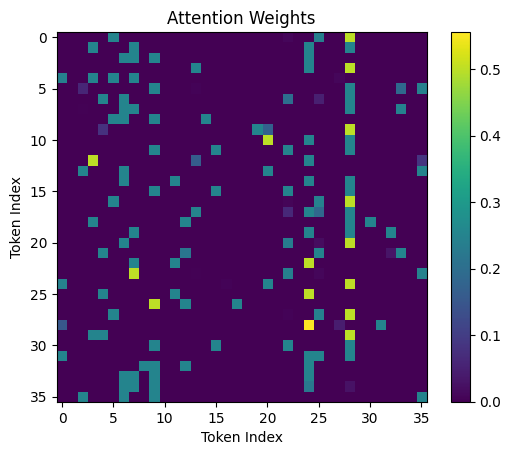

In [11]:
import os
import matplotlib.pyplot as plt


if os.path.exists("checkpoint_full.pt"):
    checkpoint = torch.load("checkpoint_full.pt", map_location=device)
    model.load_state_dict(checkpoint["model_state"])

batch = next(iter(test_iter))
x = batch.text[1:2].to(device)
mask = (x == pad_idx)

model.eval()
with torch.no_grad():
    attn_layer = model.transformer.layers[0].self_attn
    emb = model.embedding(x) * math.sqrt(model.embedding.embedding_dim)
    emb = model.pos_encoder(emb)
    attn_output, attn_weights = attn_layer(
        emb, emb, emb, key_padding_mask=mask, need_weights=True
    )

plt.imshow(attn_weights[0].cpu(), cmap="viridis")
plt.colorbar()
plt.title("Attention Weights")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()


In [12]:
tokens = [TEXT.vocab.itos[i] for i in x[0].cpu().numpy()]
print(tokens)

['the', 'claude', '<unk>', "'", 's', 'movie', 'is', 'a', 'pretty', 'good', 'moment', 'of', 'cinema', '.', 'one', 'of', 'the', 'most', 'touching', 'films', 'about', 'family', 'and', 'loneliness', ',', 'and', 'surely', 'the', 'best', 'interpretation', 'of', 'french', 'actor', '<unk>', '<unk>', '.']


In [13]:
import torch


weights = attn_weights[0].cpu().numpy()
top_pairs = torch.topk(torch.tensor(weights.flatten()), 5)

for idx in top_pairs.indices:
    i = idx // weights.shape[1]
    j = idx % weights.shape[1]
    print(f"{tokens[i]} → {tokens[j]} : attention = {weights[i, j]:.3f}")

best → , : attention = 0.556
moment → about : attention = 0.500
good → best : attention = 0.500
the → best : attention = 0.500
cinema → ' : attention = 0.500


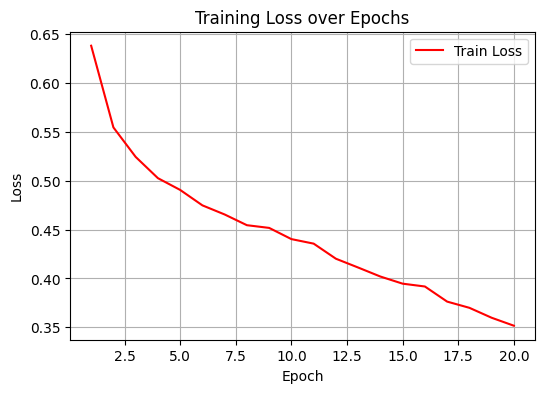

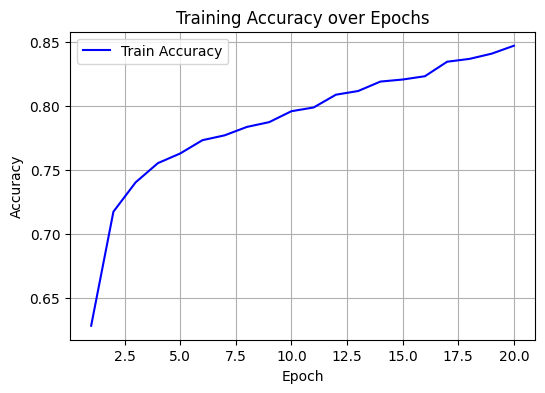

In [14]:
import csv


losses = []
accs = []
epochs = []

if os.path.exists("training_log.csv"):
    with open("training_log.csv", "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            epochs.append(int(row["epoch"]))
            losses.append(float(row["train_loss"]))
            accs.append(float(row["train_acc"]))

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, losses, label="Train Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, accs, label="Train Accuracy", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
import torch


text_example = "The movie was absolutely fantastic! I loved every part of it."

tokens = TEXT.preprocess(text_example)
numericalized = [TEXT.vocab.stoi.get(tok, unk_idx) for tok in tokens]
tensor = torch.LongTensor(numericalized).unsqueeze(0).to(device)

mask = (tensor == pad_idx)

model.eval()
with torch.no_grad():
    logits = model(tensor, src_key_padding_mask=mask)
    probs = torch.softmax(logits, dim=1)
    pred_class = probs.argmax(dim=1).item()

label = LABEL.vocab.itos[pred_class]
print(f"Predicted label: {label}")
print(f"Confidence: {probs[0][pred_class].item():.4f}")

Predicted label: pos
Confidence: 0.9967
